In [1]:
import sys
# Add the ptdraft folder path to the sys.path list
sys.path.append('../Augmentor/')
sys.path.append('../generate_license_plates-master/')

In [2]:
from generate import generateNumber
import Augmentor
import cv2
import numpy as np

In [3]:
import os
import itertools
import codecs
import re
import datetime
import cairocffi as cairo
from generate import generateNumber
import Augmentor
import cv2
import numpy as np
import editdistance
import numpy as np
import glob
from scipy import ndimage
import pylab
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD, Adam
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.models import load_model
import keras.callbacks
import random as rd
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [4]:
# character classes and matching regex filter
regex = r'^[ ABCEHKMOPTXY0123456789]+$'
alphabet = u' ABCEHKMOPTXY0123456789'

Функция перевода текста в индексы

In [5]:
# Translation of characters to unique integer values
def text_to_labels(text):
    ret = []
    if(len(text) > 10):
        print("text > 10",text)  
    for char in text:
        ch = alphabet.find(char)
        if(ch > 30):
            print("ch > 30",text)  
        if(ch == -1):
            print("text_to_labels",text, char)    
        ret.append(ch)
    
    return ret

Функция перевода индексов в тексты

In [6]:
def labels_to_text(labels):
    ret = []
    for c in labels:
        if c != 0 and c != len(alphabet):  # CTC Blank
            ret.append(alphabet[c])
    return "".join(ret)

Проверка того что наши тексты содержат только нужные нам символы

In [7]:
def is_valid_str(in_str):
    search = re.compile(regex, re.UNICODE).search
    return bool(search(in_str))

СТС функция

In [8]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Функция декодирования бача, нужна для тестирования

In [9]:
def decode_batch(test_func, word_batch):
    out = test_func([word_batch])[0]
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = labels_to_text(out_best)
        ret.append(outstr)
    return ret

Генератор бачей

In [10]:
class TextImageGenerator(keras.callbacks.Callback):
    
    def __init__(self, 
                 samples, 
                 img_w, img_h, 
                 batch_size, 
                 downsample_factor,
                 max_text_len=10,
                 gen_samples_len=10000):
        
        self.samples = samples
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.downsample_factor = downsample_factor
        
        self.n = len(self.samples) + gen_samples_len
        self.indexes = list(range(self.n))
        rd.shuffle(self.indexes)
        self.cur_index = 0
        self.augment_pipline = self.aug(img_w, img_h)
        
    def build_data(self, index):
        is_photo = index < len(self.samples)
        if is_photo:
            (img_filepath, text) = self.samples[index]
            img = cv2.imread(img_filepath, 0)
        else:
            img, text = generateNumber()
            img_array = np.asarray(bytearray(img), dtype=np.uint8)
            img = cv2.imdecode(img_array, 0)

        img = cv2.resize(img, (self.img_w, self.img_h))
            
        if not is_photo:
            img = self.saturate(img, -100, 100)
            img = self.speckle(img)
            img = np.asarray(self.augment_pipline.sample_with_array(img))
        img = img.astype(np.float32)
        img /= 255
        return img, text
        
    def get_output_size(self):
        return len(alphabet) + 1
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            rd.shuffle(self.indexes)
            
        return self.build_data(self.indexes[self.cur_index])
#         return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
    
    def next_batch(self):
        while True:
            X_data = np.zeros([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.zeros([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            source_str = []
                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i,  0:len(text)] = text_to_labels(text)
                source_str.append(text)
                label_length[i] = len(text)
                
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
                #'source_str': source_str
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
#             print(self.cur_index)
            yield (inputs, outputs)
            
    def on_epoch_begin(self, epoch, logs={}):
        # rebind the paint function to implement curriculum learning
        # if 3 <= epoch < 6:
        print("on_epoch_begin")
        
    def aug(self, w,h):
        p = Augmentor.Pipeline()
        width = int(w*1.7)
        height = int(h*1.7)
        p.zoom(probability=1, min_factor=0.6, max_factor=0.7)
        p.skew_tilt(probability=0.5,magnitude=0.4)
        p.rotate(probability=0.5, max_left_rotation=5, max_right_rotation=5)
        p.shear(probability=0.5, max_shear_left=5, max_shear_right=5)
        
#         width = w//5
#         height = h//5
#         p.random_distortion(0.25, grid_width=width, grid_height=height, magnitude=1)

#         width = w//1
#         height = h//1
#         p.random_distortion(0.25, grid_width=width, grid_height=height, magnitude=1)
      

        return p    
    
    def speckle(self, img):
        severity = np.random.uniform(0, 1) * 255
        blur = ndimage.gaussian_filter(np.random.randn(*img.shape) * severity, 3, truncate=10)
        img_speck = (img + blur)
        img_speck[img_speck > 255] = 255
        img_speck[img_speck <= 0] = 0
        img_speck = np.array(img_speck.astype(np.int32))
        return img_speck
    
    def saturate(self, image, min_sat, max_sat):
        severity = np.random.uniform(min_sat, max_sat)
        img_speck = (image + severity)
        img_speck[img_speck > 255] = 255
        img_speck[img_speck <= 0] = 0
        img_speck = np.array(img_speck.astype(np.int32))
        return img_speck

Класс отрисовки результата

In [11]:
class VizCallback(keras.callbacks.Callback):

    def __init__(self, output_dir, run_name, test_func, text_img_gen, num_display_words=6):
        self.test_func = test_func
        self.output_dir = os.path.join(
            output_dir, run_name)
        self.text_img_gen = text_img_gen
        self.num_display_words = num_display_words
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def show_edit_distance(self, num):
        num_left = num
        mean_norm_ed = 0.0
        mean_ed = 0.0
        while num_left > 0:
            word_batch = next(self.text_img_gen)[0]
            num_proc = min(word_batch['the_input'].shape[0], num_left)
            decoded_res = decode_batch(self.test_func, word_batch['the_input'][0:num_proc])
            for j in range(num_proc):
                edit_dist = editdistance.eval(decoded_res[j], labels_to_text(word_batch['the_labels'][j].astype(np.int32)))
                mean_ed += float(edit_dist)
                mean_norm_ed += float(edit_dist) / len(word_batch['the_labels'][j])
            num_left -= num_proc
        mean_norm_ed = mean_norm_ed / num
        mean_ed = mean_ed / num
        print('\nOut of %d samples:  Mean edit distance: %.3f Mean normalized edit distance: %0.3f'
              % (num, mean_ed, mean_norm_ed))

    def on_epoch_end(self, epoch, logs={}):
        self.model.save_weights(os.path.join(self.output_dir, 'weights%02d.h5' % (epoch)))
        self.show_edit_distance(350)
        word_batch = next(self.text_img_gen)[0]
        res = decode_batch(self.test_func, word_batch['the_input'][0:self.num_display_words])
        if word_batch['the_input'][0].shape[0] < 350:
            cols = 2
        else:
            cols = 1
        for i in range(self.num_display_words):
            pylab.subplot(self.num_display_words // cols, cols, i + 1)
            
            the_input = word_batch['the_input'][i, :, :, 0]
            pylab.imshow(the_input.T, cmap='Greys_r')
            pylab.xlabel('Truth = \'%s\'\nDecoded = \'%s\'' % (labels_to_text(word_batch['the_labels'][i].astype(np.int32)), res[i]))
        fig = pylab.gcf()
        fig.set_size_inches(10, 13)
        pylab.savefig(os.path.join(self.output_dir, 'e%02d.png' % (epoch)))
        pylab.close()

Функция взятия номера из названия файла фото

In [12]:
searchNum = re.compile("([A-Z ]+[0-9]+[A-Z ]+[0-9]+)")
def get_images(images_path):
    images = []
    files_images = glob.iglob(os.path.join(images_path, "*.png"))
    for image_path in files_images:
        name = searchNum.findall(image_path)[0]
        if(len(name) < 6):
            print(name)
        images.append((image_path, name.replace(' ','')))
        
        
    # print(images)
    return np.array(images)

Функция тренировки

In [49]:
def train(run_name, start_epoch, stop_epoch, img_w = 128, img_h = 64):


    K.set_learning_phase(1)
    fdir = os.path.expanduser(os.path.join('train296x96/'))
    images = get_images(fdir) #[-100:]
  
    # Input Parameters
   
    gen_samples_len = 10000  

    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 128 #512
    minibatch_size = 32
    
    images = images[: len(images) - (len(images) % minibatch_size)]
    rd.shuffle(images)
    words_per_epoch = len(images)
    val_split = 0.2
    val_words = int(((len(images) + gen_samples_len) * val_split) - \
                    (((len(images) + gen_samples_len) * val_split) % minibatch_size))#int(round(words_per_epoch * (val_split)))
    print("len train",len(images))
    print("len val",val_words)
    input_shape = (img_w, img_h, 1)

    
    max_pool_layers = 2
    

    img_gen = TextImageGenerator(samples=images,
                                 img_w=img_w,
                                 img_h=img_h,
                                 batch_size=minibatch_size,
                                 downsample_factor=(pool_size ** max_pool_layers),
                                 gen_samples_len=gen_samples_len)
#     img_gen.build_data()
    
    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
#     inner = Conv2D(conv_filters, kernel_size, padding='same',
#                    activation=act, kernel_initializer='he_normal',
#                    name='conv0')(input_data)
#     inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max0')(input_data)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)
   
    print("inner.shape", inner.shape)
    conv_to_rnn_dims = (img_w // (pool_size ** max_pool_layers), (img_h // (pool_size ** max_pool_layers)) * conv_filters)
    print("conv_to_rnn_dims", conv_to_rnn_dims)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

    # Two layers of bidirectional GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(img_gen.get_output_size(), kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    # Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[img_gen.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int32')
    label_length = Input(name='label_length', shape=[1], dtype='int32')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    print("y_pred: {}\nlabels: {}\ninput_length: {}\nlabel_length: {}".format(y_pred, labels, input_length, label_length))
    # print("max(labels.indices(labels.indices[:, 1] == b, 2))", max(labels.indices()))
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    # adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    model.summary()
    if start_epoch > 0:
        weight_file = os.path.join(os.path.join("output",run_name), 'weights%02d.h5' % (start_epoch - 1))
        model.load_weights(weight_file)
    # captures output of softmax so we can decode the output during visualization
    test_func = K.function([input_data], [y_pred])

    viz_cb = VizCallback("output", run_name, test_func, img_gen.next_batch())
#     model.save("model_data/model.h5")
    model.fit_generator(generator=img_gen.next_batch(),
                        steps_per_epoch=img_gen.n // minibatch_size,
                        epochs=stop_epoch,
                        validation_data=img_gen.next_batch(),
                        validation_steps=val_words // minibatch_size,
                        callbacks=[viz_cb, img_gen],
                        initial_epoch=start_epoch)

Тренировка

In [51]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))
run_name = "train148x48" #datetime.datetime.now().strftime('%Y:%m:%d:%H:%M:%S')
train(run_name, 3, 100, img_w = 148, img_h = 64)
# increase to wider images and start at epoch 20. The learned weights are reloaded
# train(run_name, 20, 25)

len train 2784
len val 2528
inner.shape (?, 37, 16, 16)
conv_to_rnn_dims (37, 256)
y_pred: Tensor("softmax_2/truediv:0", shape=(?, 37, 24), dtype=float32)
labels: Tensor("the_labels_1:0", shape=(?, 10), dtype=float32)
input_length: Tensor("input_length_1:0", shape=(?, 1), dtype=int32)
label_length: Tensor("label_length_1:0", shape=(?, 1), dtype=int32)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
the_input (InputLayer)           (None, 148, 64, 1)    0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 148, 64, 16)   160         the_input[0][0]                  
____________________________________________________________________________________________________
max1 (MaxPooling2D)              (None, 

399/399 [==============================] - 379s - loss: 2.5650 - val_loss: 2.1638
on_epoch_begin
Epoch 16/100
398/399 [============================>.] - ETA: 0s - loss: 2.3327
Out of 350 samples:  Mean edit distance: 0.534 Mean normalized edit distance: 0.053
399/399 [==============================] - 383s - loss: 2.3360 - val_loss: 2.0675
on_epoch_begin
Epoch 17/100
398/399 [============================>.] - ETA: 0s - loss: 2.0014
Out of 350 samples:  Mean edit distance: 0.671 Mean normalized edit distance: 0.067
399/399 [==============================] - 375s - loss: 2.0013 - val_loss: 1.9069
on_epoch_begin
Epoch 18/100
398/399 [============================>.] - ETA: 0s - loss: 1.7945
Out of 350 samples:  Mean edit distance: 0.514 Mean normalized edit distance: 0.051
399/399 [==============================] - 377s - loss: 1.7914 - val_loss: 1.6616
on_epoch_begin
Epoch 19/100
398/399 [============================>.] - ETA: 0s - loss: 1.5992
Out of 350 samples:  Mean edit distance: 0.4

399/399 [==============================] - 354s - loss: 0.3803 - val_loss: 0.3227
on_epoch_begin
Epoch 79/100
398/399 [============================>.] - ETA: 0s - loss: 0.4218
Out of 350 samples:  Mean edit distance: 0.131 Mean normalized edit distance: 0.013
399/399 [==============================] - 355s - loss: 0.4213 - val_loss: 0.3657
on_epoch_begin
Epoch 80/100
398/399 [============================>.] - ETA: 0s - loss: 0.3943
Out of 350 samples:  Mean edit distance: 0.049 Mean normalized edit distance: 0.005
399/399 [==============================] - 353s - loss: 0.3954 - val_loss: 0.2909
on_epoch_begin
Epoch 81/100
398/399 [============================>.] - ETA: 0s - loss: 0.3762
Out of 350 samples:  Mean edit distance: 0.094 Mean normalized edit distance: 0.009
399/399 [==============================] - 355s - loss: 0.3759 - val_loss: 0.3820
on_epoch_begin
Epoch 82/100
398/399 [============================>.] - ETA: 0s - loss: 0.3532
Out of 350 samples:  Mean edit distance: 0.0

## Проверяем результат оставив только реальные фото

In [52]:
def decode_batch_test(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(alphabet):
                outstr += alphabet[c]
        ret.append(outstr)
    return ret

In [59]:
def get_model(run_name, start_epoch, img_w = 128, img_h = 64, gen_samples_len = 10000):


    K.set_learning_phase(0)
    fdir = os.path.expanduser(os.path.join('train296x96/'))
    images = get_images(fdir)
  
    # Input Parameters
   
    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 128
    minibatch_size = 32
    
    images = images[: len(images) - (len(images) % minibatch_size)]
    rd.shuffle(images)
    words_per_epoch = len(images)
    val_split = 0.2
    val_words = int(((len(images) + gen_samples_len) * val_split) - \
                    (((len(images) + gen_samples_len) * val_split) % minibatch_size))#int(round(words_per_epoch * (val_split)))
    print("len train",len(images))
    print("len val",val_words)
    input_shape = (img_w, img_h, 1)

    
    max_pool_layers = 2
    

    img_gen = TextImageGenerator(samples=images,
                                 img_w=img_w,
                                 img_h=img_h,
                                 batch_size=minibatch_size,
                                 downsample_factor=(pool_size ** max_pool_layers),
                                 gen_samples_len=gen_samples_len)
#     img_gen.build_data()
    
    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
#     inner = Conv2D(conv_filters, kernel_size, padding='same',
#                    activation=act, kernel_initializer='he_normal',
#                    name='conv0')(input_data)
#     inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max0')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)
   
    print("inner.shape", inner.shape)
    conv_to_rnn_dims = (img_w // (pool_size ** max_pool_layers), (img_h // (pool_size ** max_pool_layers)) * conv_filters)
    print("conv_to_rnn_dims", conv_to_rnn_dims)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

    # Two layers of bidirectional GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(img_gen.get_output_size(), kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    # Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[img_gen.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int32')
    label_length = Input(name='label_length', shape=[1], dtype='int32')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    print("y_pred: {}\nlabels: {}\ninput_length: {}\nlabel_length: {}".format(y_pred, labels, input_length, label_length))
    # print("max(labels.indices(labels.indices[:, 1] == b, 2))", max(labels.indices()))
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    # adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    model.summary()
    
    weight_file = os.path.join(os.path.join("output",run_name), 'weights%02d.h5' % (start_epoch))
    print(weight_file)
    model.load_weights(weight_file)
    return model, img_gen

len train 2784
len val 544
inner.shape (?, 37, 16, 16)
conv_to_rnn_dims (37, 256)
y_pred: Tensor("softmax_6/truediv:0", shape=(?, 37, 24), dtype=float32)
labels: Tensor("the_labels_5:0", shape=(?, 10), dtype=float32)
input_length: Tensor("input_length_5:0", shape=(?, 1), dtype=int32)
label_length: Tensor("label_length_5:0", shape=(?, 1), dtype=int32)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
the_input (InputLayer)           (None, 148, 64, 1)    0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 148, 64, 16)   160         the_input[0][0]                  
____________________________________________________________________________________________________
max1 (MaxPooling2D)              (None, 7

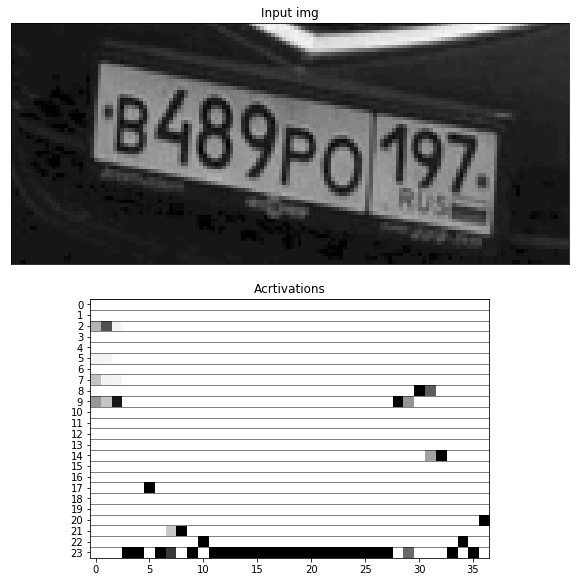

Predicted: B489PO197
True: B489PO197 


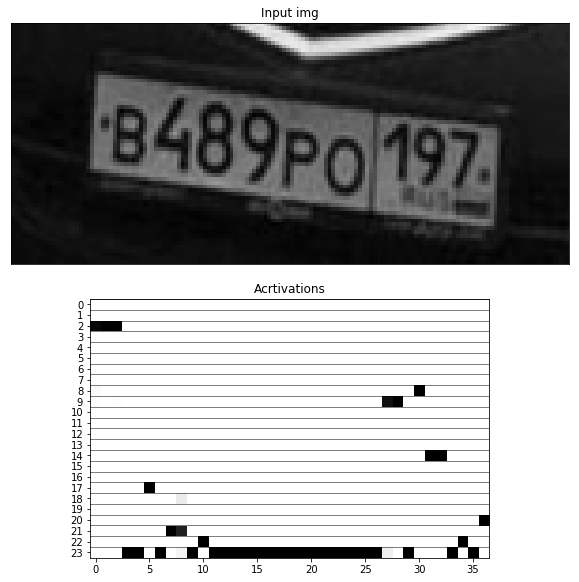

Predicted: H274BT163
True: T274BT163 


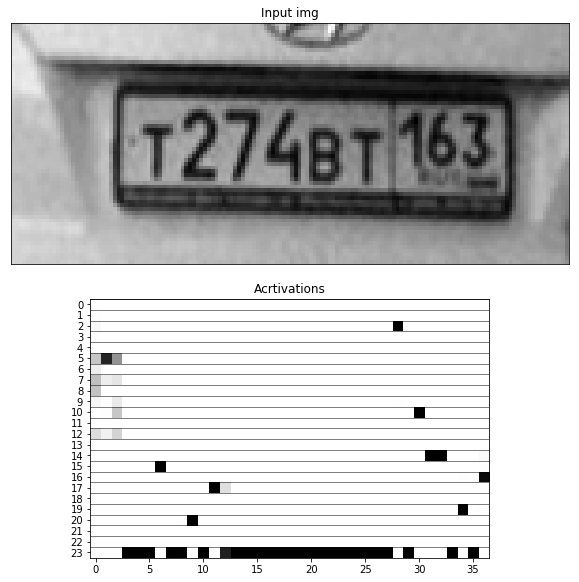

Predicted: B227OO178
True: B227OO178 


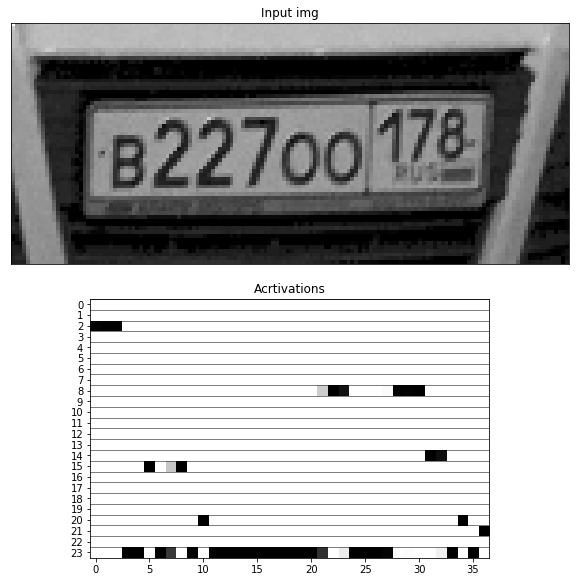

Predicted: E729ET50
True: E729ET750 


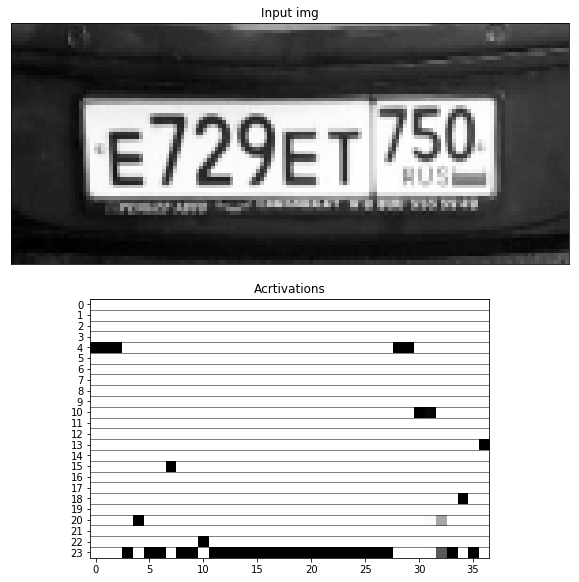

Predicted: E363AO178
True: E363AO178 


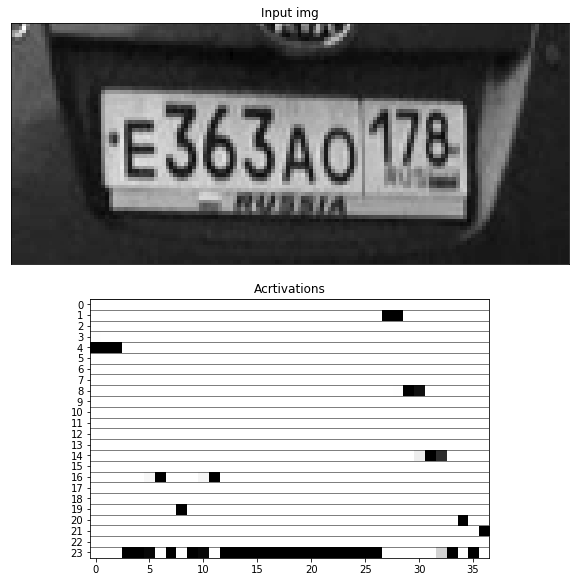

Predicted: H801CP177
True: M801CP178 


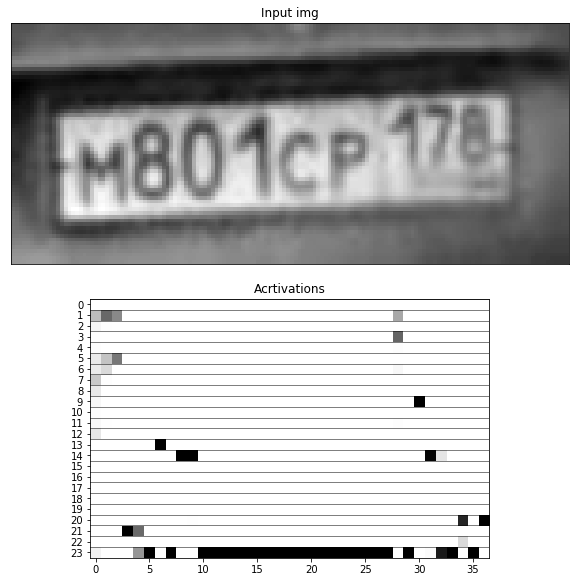

Predicted: B979BA190
True: B979BA190 


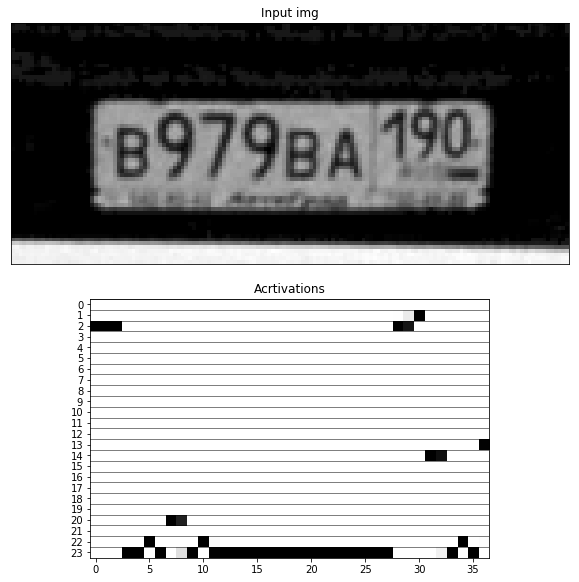

Predicted: A344OA197
True: A344OA197 


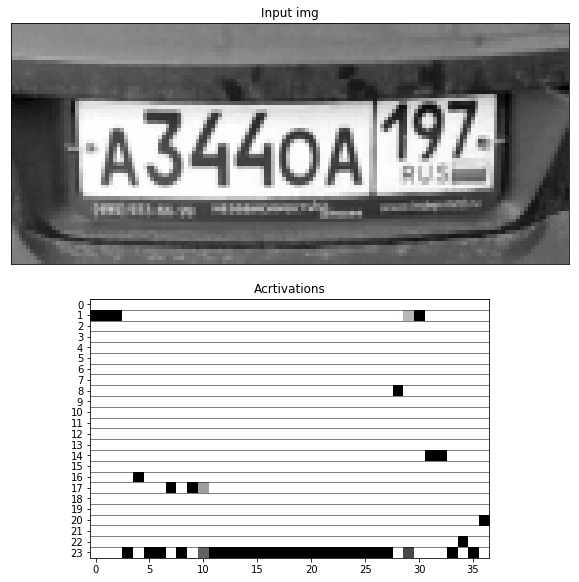

Predicted: C018YT190
True: C018YT190 


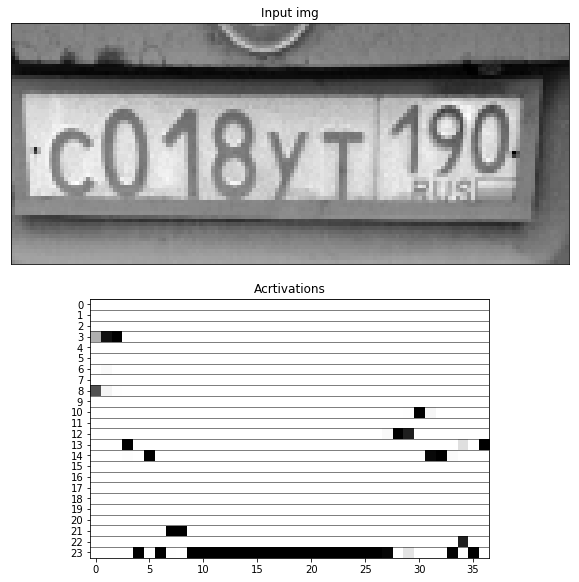

Predicted: E444OM99
True: E444OM99  


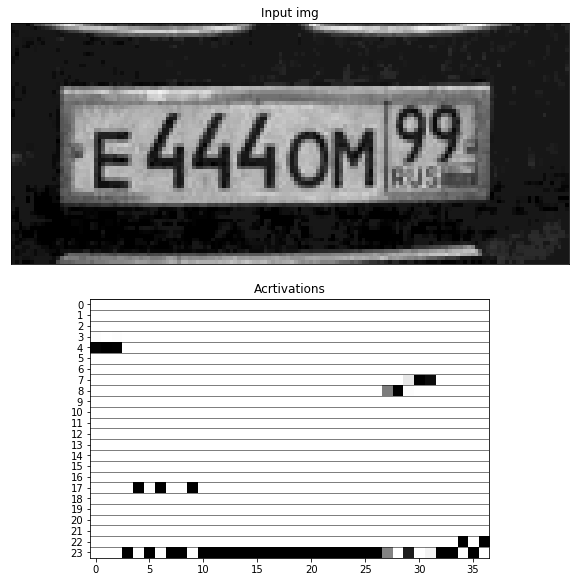

Predicted: H769EPM07
True: H769EM07  


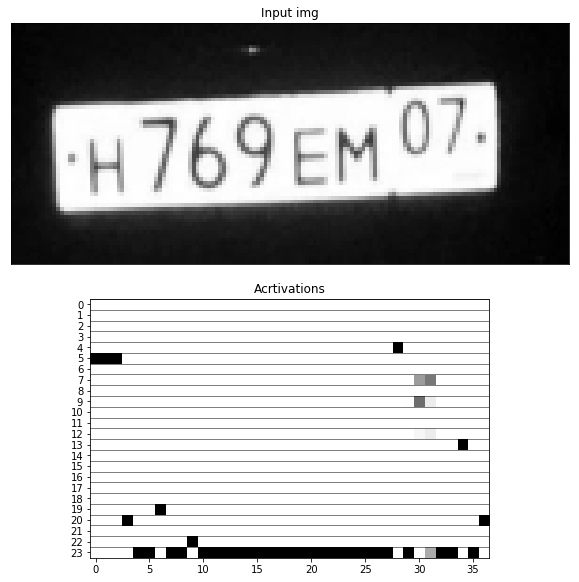

Predicted: C003AO197
True: C003AO197 


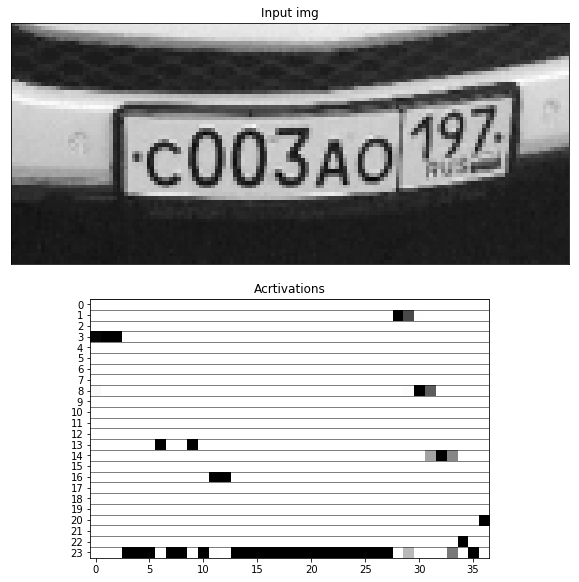

Predicted: A842OT178
True: A842OT178 


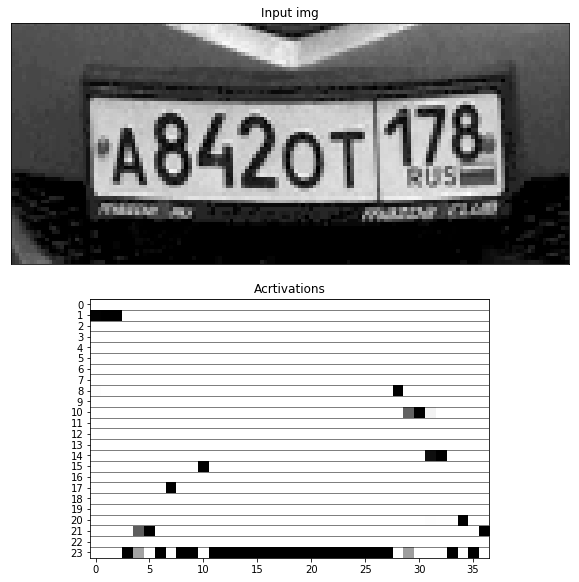

Predicted: H007EY47
True: H007EY47  


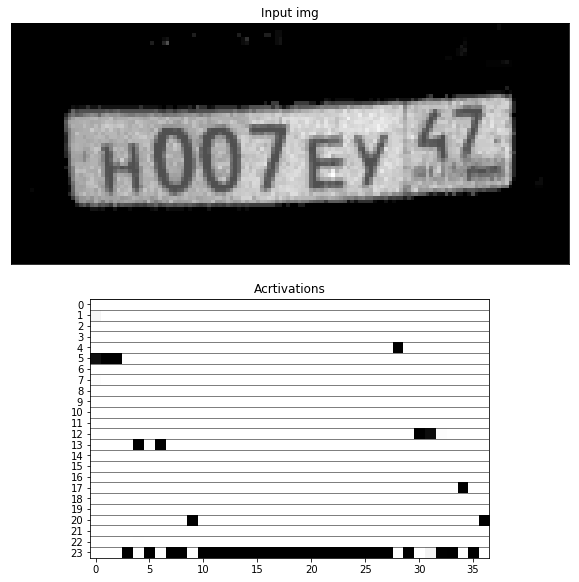

Predicted: C366YT59
True: C366YT59  


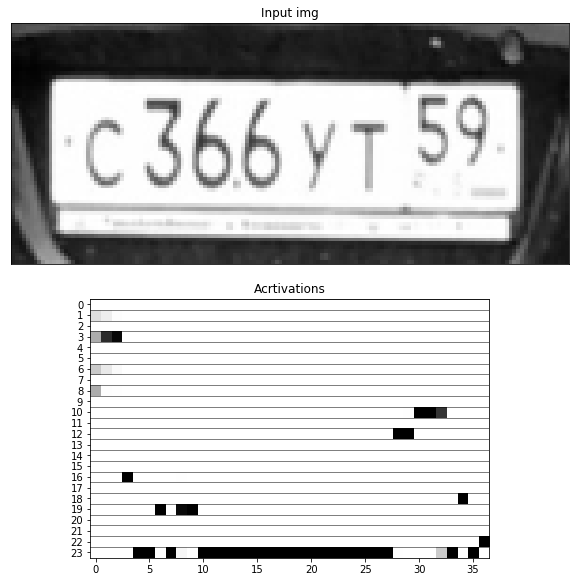

Predicted: K693CH93
True: K693CH93  


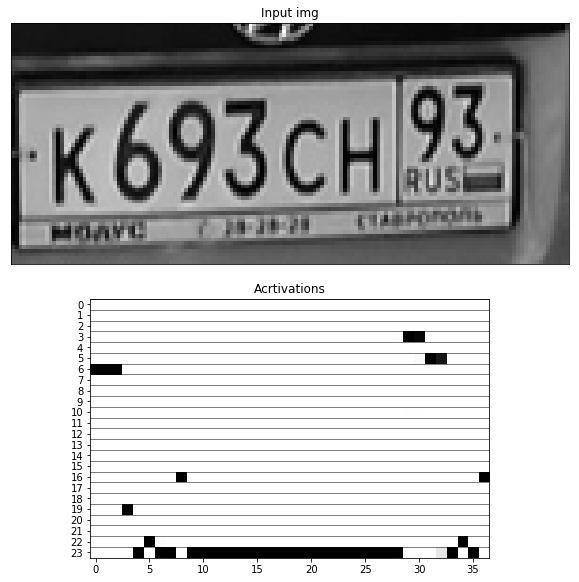

Predicted: B542OX177
True: B542OX177 


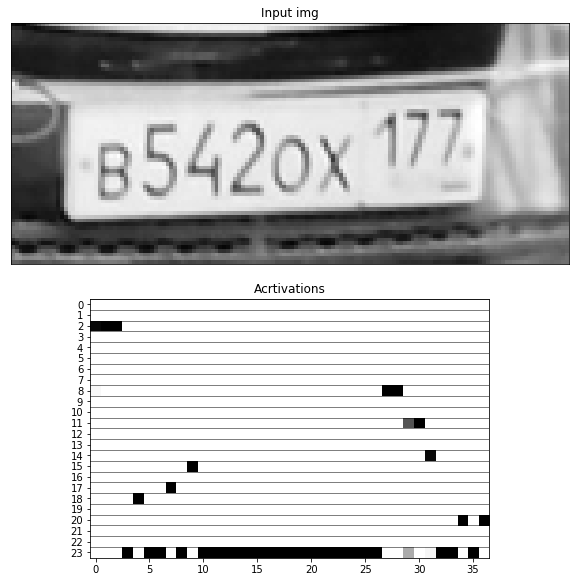

Predicted: K160TM178
True: K160TM178 


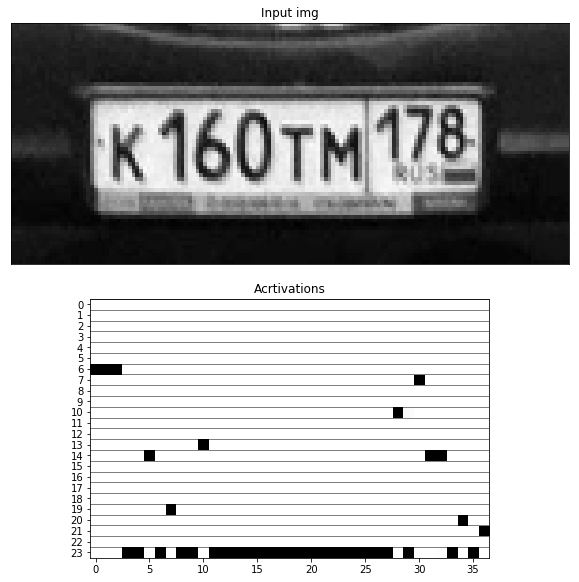

Predicted: B250MO77
True: B250MO77  


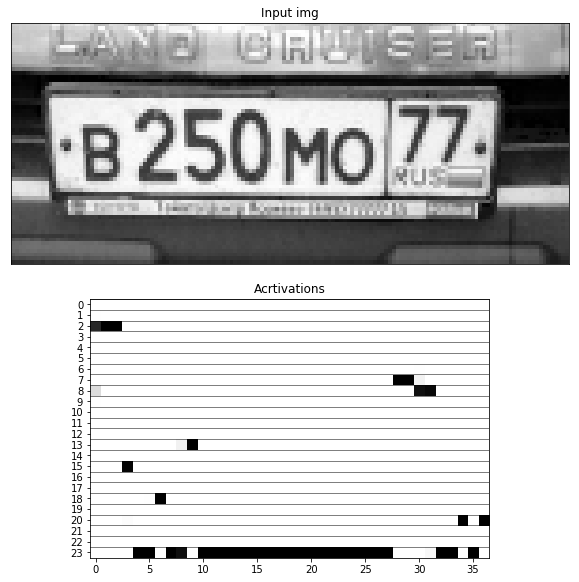

Predicted: B302HB178
True: B302HB178 


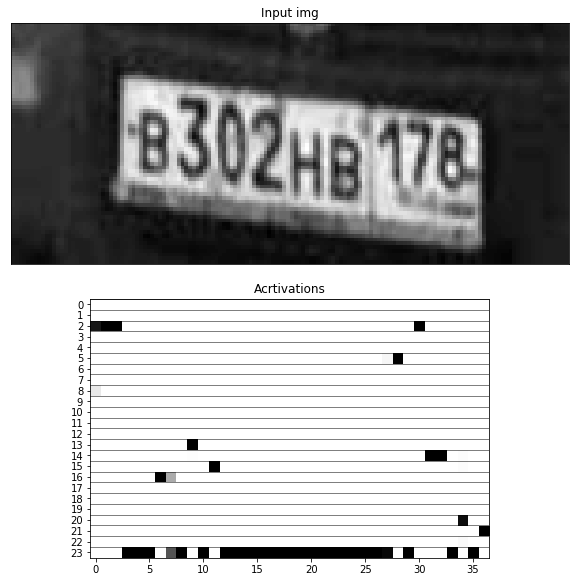

Predicted: B953OK159
True: B953OK159 


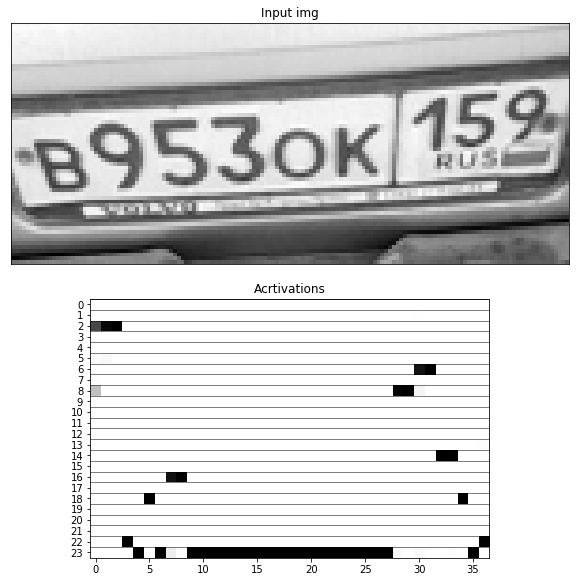

Predicted: A278HE177
True: A278HE177 


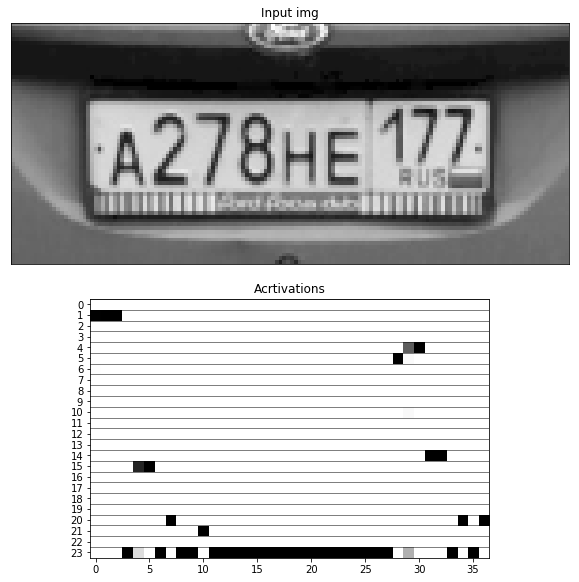

Predicted: E397MO163
True: E397MO163 


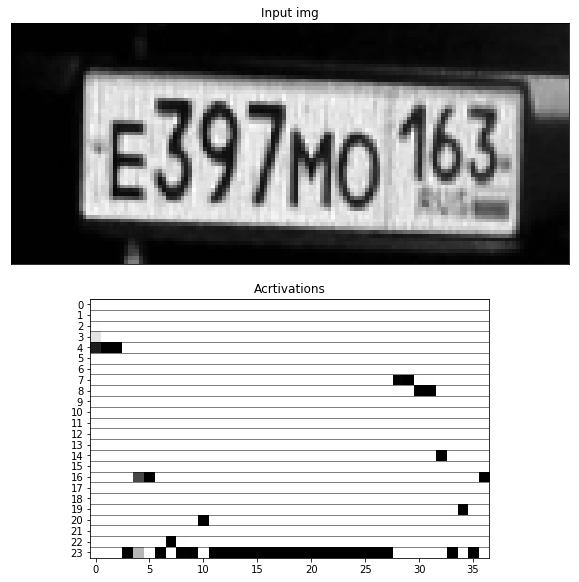

Predicted: A000AA00
True: A000AA00  


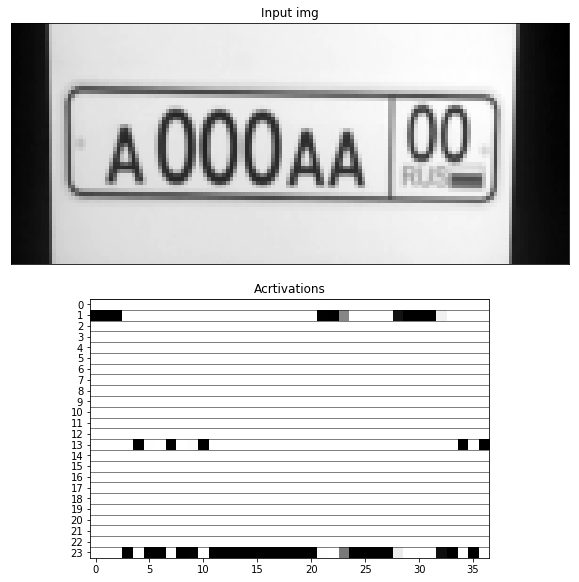

Predicted: A178ET178
True: A178ET178 


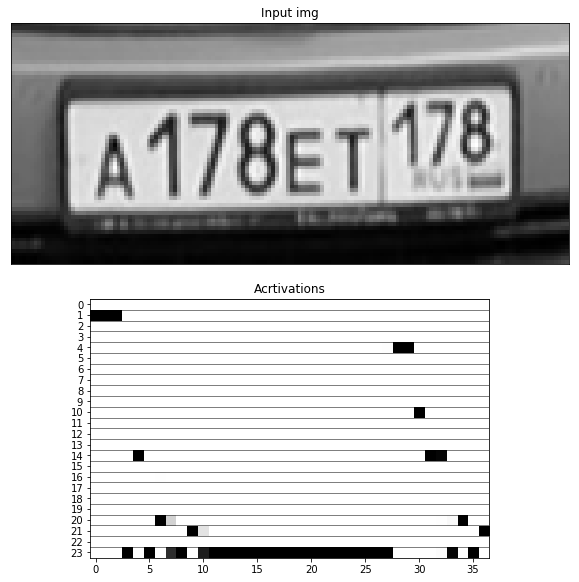

Predicted: B759OC62
True: B759OC62  


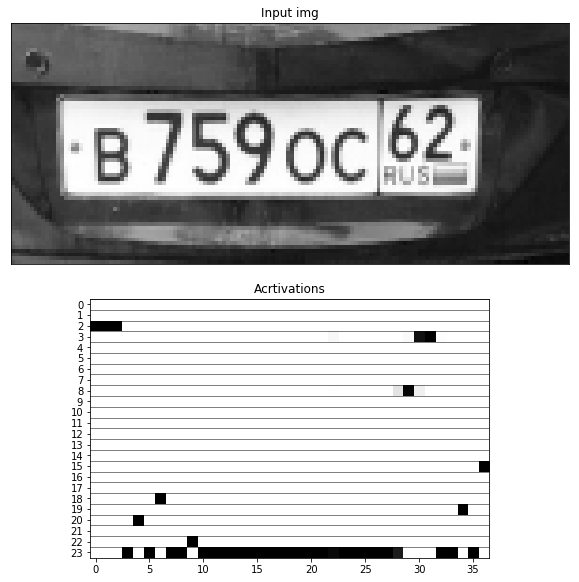

Predicted: C212KX77
True: C212KX77  


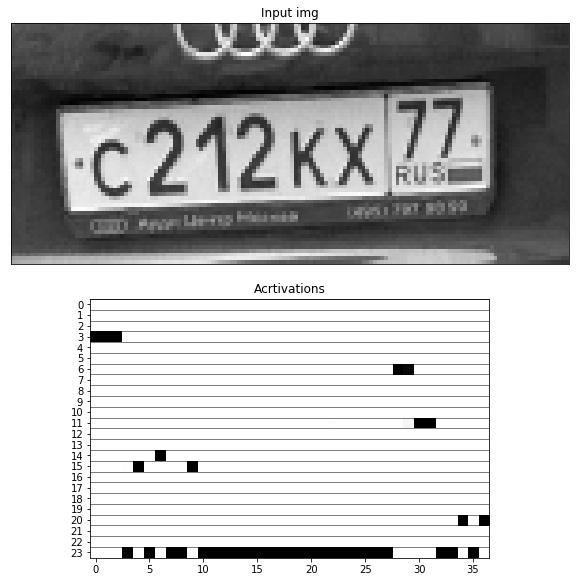

Predicted: A037OA134
True: A037OA134 


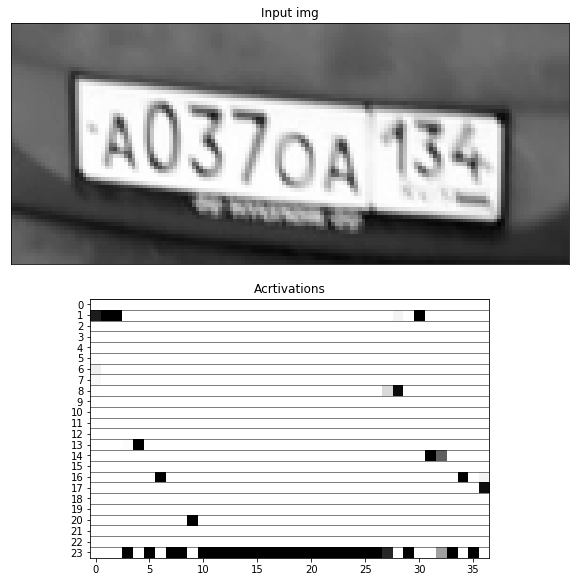

Predicted: A122TB177
True: A122TB177 


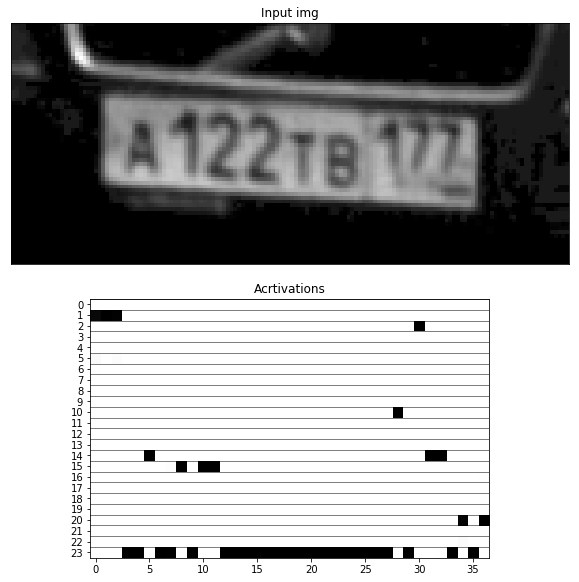

Predicted: H214AP77
True: H214AP77  


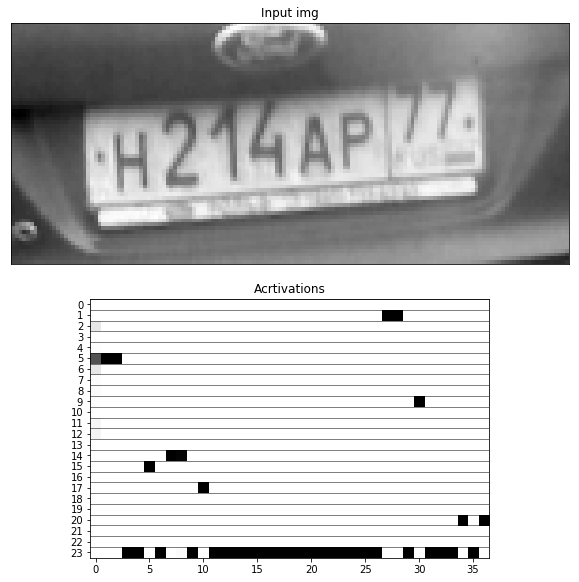

Predicted: Y330MK178
True: M330MK178 


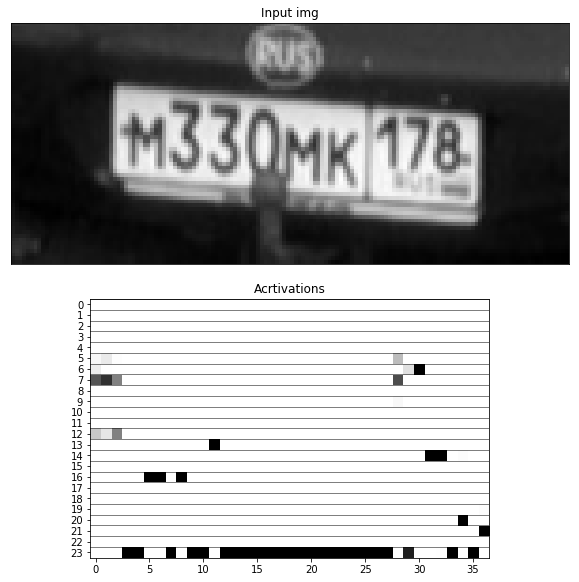

In [61]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


model, data_test = get_model(run_name, 70, img_w = 148, img_h = 64, gen_samples_len=0)
# data_test.build_data()

net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

sess = K.get_session()
# index = 0
# for k, l in data_test.next_batch():
#     index += 1
#     if index == 5:
#         break
    
    
for inp_value, _ in data_test.next_batch():
    bs = inp_value['the_input'].shape[0]
    X_data = inp_value['the_input']
    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decode_batch_test(net_out_value)
    labels = inp_value['the_labels']
    texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: alphabet[int(x)], label)))
        texts.append(text)
    
    for i in range(bs):
        fig = plt.figure(figsize=(10, 10))
        outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
        ax1 = plt.Subplot(fig, outer[0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[1])
        fig.add_subplot(ax2)
        print('Predicted: %s\nTrue: %s' % (pred_texts[i], texts[i]))
        img = X_data[i][:, :, 0].T
        ax1.set_title('Input img')
        ax1.imshow(img, cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_title('Acrtivations')
        ax2.imshow(net_out_value[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(alphabet) + 1)))
#          pylab.xlabel('Truth = \'%s\'\nDecoded = \'%s\'' % (labels_to_text(word_batch['the_labels'][i].astype(np.int32)), res[i]))
#         ax2.set_yticklabels(labels_to_text(alphabet.astype(np.int32)) + ['blank'])
        ax2.grid(False)
        for h in np.arange(-0.5, len(alphabet) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
        
        #ax.axvline(x, linestyle='--', color='k')
        plt.show()
    break

## Подготовим данные к выгрузке в Андроид

Сохраним только нужную нам часть модели

In [65]:
def save_model():
    # Input Parameters
    img_h = 64
    img_w = 148
   

    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 128
    minibatch_size = 32
    
    input_shape = (img_w, img_h, 1)

    
    max_pool_layers = 2
    

    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
#     inner = Conv2D(conv_filters, kernel_size, padding='same',
#                    activation=act, kernel_initializer='he_normal',
#                    name='conv0')(input_data)
#     inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max0')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)
   
    print("inner.shape", inner.shape)
    conv_to_rnn_dims = (img_w // (pool_size ** max_pool_layers), (img_h // (pool_size ** max_pool_layers)) * conv_filters)
    print("conv_to_rnn_dims", conv_to_rnn_dims)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

    # Two layers of bidirectional GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense((len(alphabet) + 1), kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)

    model = Model(inputs=input_data, outputs=y_pred)
    model.summary()
    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    # model.compile(loss={'softmax': lambda y_true, y_pred: y_pred}, optimizer="adam")
    model.save(os.path.join('model_data', 'model_finish_148.h5'))

    # sess = K.get_session()
    # export_base_path = 'tf-exports'
    # with open(os.path.join(export_base_path, "graph.pb"), "wb") as fout:
    #     fout.write(sess.graph.as_graph_def().SerializeToString())
    # print("Written graph.")

    return model

In [66]:
save_model()

inner.shape (?, 37, 16, 16)
conv_to_rnn_dims (37, 256)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
the_input (InputLayer)           (None, 148, 64, 1)    0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 148, 64, 16)   160         the_input[0][0]                  
____________________________________________________________________________________________________
max1 (MaxPooling2D)              (None, 74, 32, 16)    0           conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Conv2D)                   (None, 74, 32, 16)    2320        max1[0][0]                       
____________________________________

Выгрузим protobuf и checkpoint

In [5]:
def save_to_android(input_node_name, output_node_name):
    export_base_path = 'tf-exports'
    
    K.set_learning_phase(0)
    # model = simple_model2()
    model = load_model(os.path.join('model_data', 'model_finish.h5'), compile=False)
    model.load_weights(os.path.join('output/train296x96/', 'weights10.h5'))
    outputs_dict = list([(layer.name, layer.output) for layer in model.layers])
    print(outputs_dict)
    sess = K.get_session()
    gd = sess.graph_def
   
    protobuf_path = os.path.join(export_base_path, 'protobuf_path.pbtxt')
    checkpoint_path = os.path.join(export_base_path, 'checkpoint_path.ckpt')

    tf.train.write_graph(gd, '.', protobuf_path)

    saver = tf.train.Saver()
    saver.save(sess, save_path = checkpoint_path)

    print("output_frozen_graph_name 1")

Запустим выгрузку

In [6]:
K.clear_session()
input_name = ["the_input"]
output_name = 'softmax/truediv' 
save_to_android(input_name, output_name)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
[('the_input', <tf.Tensor 'the_input:0' shape=(?, 296, 96, 1) dtype=float32>), ('conv0', <tf.Tensor 'conv0/Relu:0' shape=(?, 296, 96, 16) dtype=float32>), ('max0', <tf.Tensor 'max0/MaxPool:0' shape=(?, 148, 48, 16) dtype=float32>), ('conv1', <tf.Tensor 'conv1/Relu:0' shape=(?, 148, 48, 16) dtype=float32>), ('max1', <tf.Tensor 'max1/MaxPool:0' shape=(?, 74, 24, 16) dtype=float32>), ('conv2', <tf.Tensor 'conv2/Relu:0' shape=(?, 74, 24, 16) dtype=float32>), ('max2', <tf.Tensor 'max2/MaxPool:0' shape=(?, 37, 12, 16) dtype=float32>), ('reshape', <tf.Tensor 'reshape/Reshape:0' shape=(?, 37, 192) dtype=float32>), ('dense1', <tf.Tensor 'dense1/Relu:0' shape=(?, 37, 32) dtype=float32>), ('gru1', <tf.Tensor 'gru1/transpose_1:0' shape=(?, ?, 512) dtype=float32>), ('gru1_b', <tf.Tensor 'gru1_b/transpose_1:0' shape=(?, ?, 512) dtype=float32>), ('add_5', <